In [1]:
"""
- Do attention values offer new insights on pathways?

Adham Beyki
PRaDA - A2I2 - Deakin University
2018-11-20
"""

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [2]:
RESULTS_PATH = "exp6.pkl"
PATHWAY_DATA_PATH = '../data/pathway_data.pkl'

In [3]:
# read data
results_data = pd.read_pickle(RESULTS_PATH)
data = pd.read_pickle(PATHWAY_DATA_PATH)

pathway_df = data['pathway_df']
train_idxs, test_idxs = data['train_idxs'], data['test_idxs']
betas = np.squeeze(results_data['betas']).astype(np.float)

# ground truth
c2i = {'LumA':1, 'LumB': 0}
y_test = pathway_df.loc[test_idxs]['PAM50'].tolist()
y_test = np.array([c2i[yy] for yy in y_test])

In [24]:
# for Thom
import feather

df = pd.DataFrame(np.squeeze(results_data['betas']))
df.columns = pathway_df.columns[:-2]
df['predict'] = results_data['preds']
df['true'] = y_test

feather.write_dataframe(df, 'thom.feather')

dict_keys(['test_idxs', 'betas', 'y_hat', 'y'])

Text(0, 0.5, 'patients')

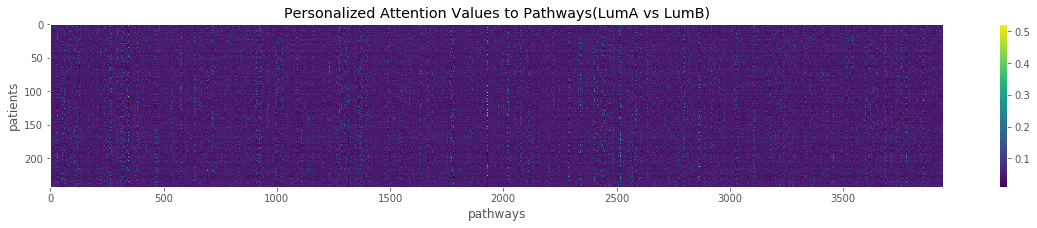

In [4]:
# plot attention values
fig, ax = plt.subplots(figsize=(20, 3))
cax = ax.imshow(np.power(betas, 1/3), aspect='auto')
fig.colorbar(cax)
ax.grid(False)
ax.set_title('Personalized Attention Values to Pathways(LumA vs LumB)')
ax.set_xlabel('pathways')
ax.set_ylabel('patients')

Text(0, 0.5, 'patients')

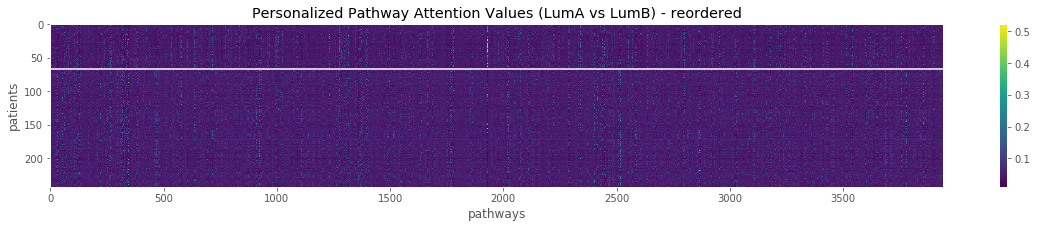

In [5]:
fig, ax = plt.subplots(figsize=(20, 3))
cax = ax.imshow(
    np.power(np.vstack([betas[y_test==0], betas[y_test==1]]), 1/3), 
    aspect='auto'
)
ax.hlines(betas[y_test==0].shape[0], 0, betas.shape[1]-1, 'w')
fig.colorbar(cax)
ax.grid(False)
ax.set_title('Personalized Pathway Attention Values (LumA vs LumB) - reordered')
ax.set_xlabel('pathways')
ax.set_ylabel('patients')

In [6]:
# top pathways for LumA and LumB based on attention values

betas_b = betas[y_test == 0]
betas_a = betas[y_test == 1]

LumA_top_pw = []
for sample_attn in betas_a:
    sample_top_idxs = sample_attn.argsort()[::-1][:5]
    LumA_top_pw += pathway_df.columns[sample_top_idxs].tolist()
    
LumB_top_pw = []
for sample_attn in betas_b:
    sample_top_idxs = sample_attn.argsort()[::-1][:5]
    LumB_top_pw += pathway_df.columns[sample_top_idxs].tolist()
    
LumA_top_pw = Counter(LumA_top_pw)
LumB_top_pw = Counter(LumB_top_pw)

In [7]:
(y_test==1).sum()

176

Text(0, 0.5, 'number of samples')

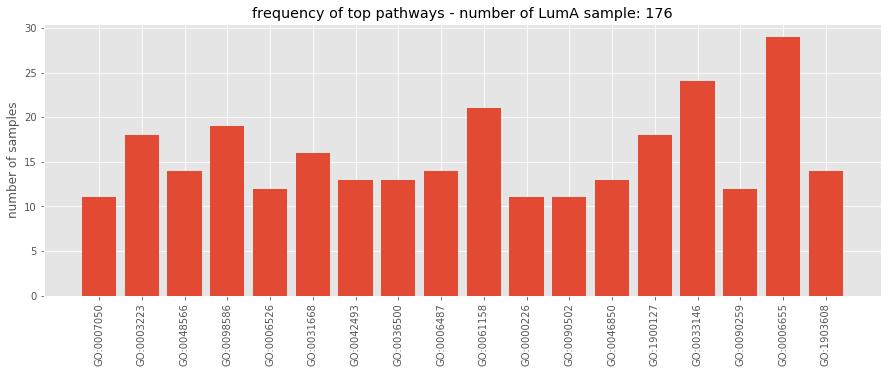

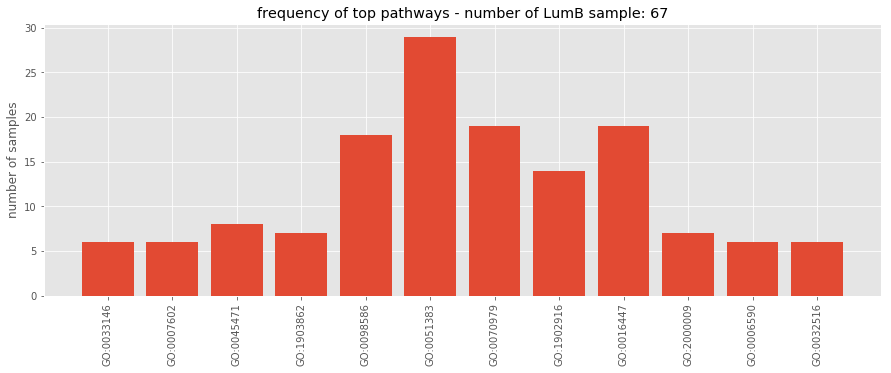

In [8]:
freqs, pw_labels = [], []
for k, v in LumA_top_pw.items():
    if v>10:
        freqs.append(v)
        pw_labels.append(k)

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(freqs)), freqs)
ax.set_xticks(np.arange(len(pw_labels)))
ax.set_xticklabels(pw_labels, rotation=90)
ax.set_title('frequency of top pathways - number of LumA sample: {}'.format((y_test==1).sum()))
ax.set_ylabel('number of samples')

freqs, pw_labels = [], []
for k, v in LumB_top_pw.items():
    if v>5:
        freqs.append(v)
        pw_labels.append(k)

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(len(freqs)), freqs)
ax.set_xticks(np.arange(len(pw_labels)))
ax.set_xticklabels(pw_labels, rotation=90)
ax.set_title('frequency of top pathways - number of LumB sample: {}'.format((y_test==0).sum()))
ax.set_ylabel('number of samples')

<hr>

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from sklearn import metrics

In [10]:
# kmeans = KMeans(n_clusters=2)
# kmeans.fit(betas)

# # check if labels have switched
# kmeans.labels_[y_test==1]

# print(metrics.classification_report(y_test, kmeans.labels_))
# print(metrics.confusion_matrix(y_test, kmeans.labels_))

In [13]:
ax.hlines?

Signature: ax.hlines(y, xmin, xmax, colors='k', linestyles='solid', label='', *, data=None, **kwargs)
Docstring:
Plot horizontal lines at each *y* from *xmin* to *xmax*.

Parameters
----------
y : scalar or sequence of scalar
    y-indexes where to plot the lines.

xmin, xmax : scalar or 1D array_like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have same length.

colors : array_like of colors, optional, default: 'k'

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional

label : string, optional, default: ''

Returns
-------
lines : `~matplotlib.collections.LineCollection`

Other Parameters
----------------
**kwargs :  `~matplotlib.collections.LineCollection` properties.

See also
--------
vlines : vertical lines
axhline: horizontal line across the axes

.. note::
    In addition to the above described arguments, this function can take a
    **data** keyword argument. If such a **data** argument is given, the
    following argume

Text(0.5, 1.0, 'NMF weight matrix for attention weights')

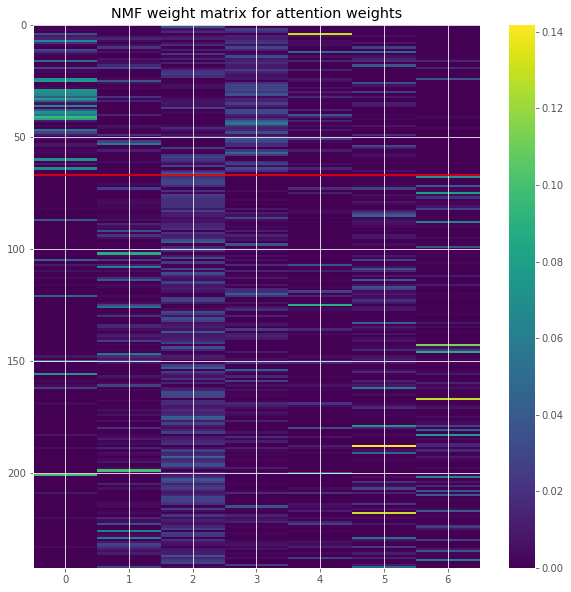

In [19]:
# Apply NMF on attention values and 

nmf = NMF(n_components=7, init='random', random_state=1)
W = nmf.fit_transform(betas)
H = nmf.components_

kmeans = KMeans(n_clusters=2)
kmeans.fit(W)

fig, ax = plt.subplots(figsize=(10, 10))
W_ = np.vstack([W[y_test==0], W[y_test==1]])
cax = ax.imshow(W_, aspect='auto')
fig.colorbar(cax)
ax.hlines((y_test==0).sum(), -0.5, 6.5, colors='r')
ax.set_title('NMF weight matrix for attention weights')

In [9]:
# kmeans = KMeans(n_clusters=2)
# kmeans.fit(W[:, 0].reshape(-1, 1))
# kmeans.fit(W)

# # check if labels have switched
# kmeans.labels_[y_test==1]

# corrected_labels = (~kmeans.labels_.astype(bool)).astype(int)
# corrected_labels = kmeans.labels_
# print(metrics.classification_report(y_test, corrected_labels))
# metrics.confusion_matrix(y_test, corrected_labels)

W obtained from NMF on attention values

factor 0
GO:0051383 1.3531
GO:0016447 0.2879
GO:1902916 0.1729
GO:0007077 0.0817
GO:0007256 0.0537

factor 1
GO:0033146 0.8262
GO:0003223 0.1986
GO:0006903 0.1236
GO:2000352 0.1145
GO:0046850 0.1014

factor 2
GO:0006655 0.1945
GO:1903608 0.1914
GO:0042493 0.1520
GO:0001963 0.1261
GO:1900127 0.1216

factor 3
GO:0098586 0.4974
GO:0070979 0.4191
GO:1903862 0.3193
GO:1902916 0.2339
GO:0045471 0.1777

factor 4
GO:0060047 0.7273
GO:0016447 0.2788
GO:0070979 0.2482
GO:0007602 0.0869
GO:0032095 0.0624

factor 5
GO:1903307 0.4464
GO:0060738 0.2378
GO:0006487 0.1210
GO:0098586 0.1209
GO:0030277 0.0945

factor 6
GO:0061158 0.6907
GO:0031668 0.4391
GO:0008219 0.1204
GO:2000178 0.0788
GO:0007296 0.0616


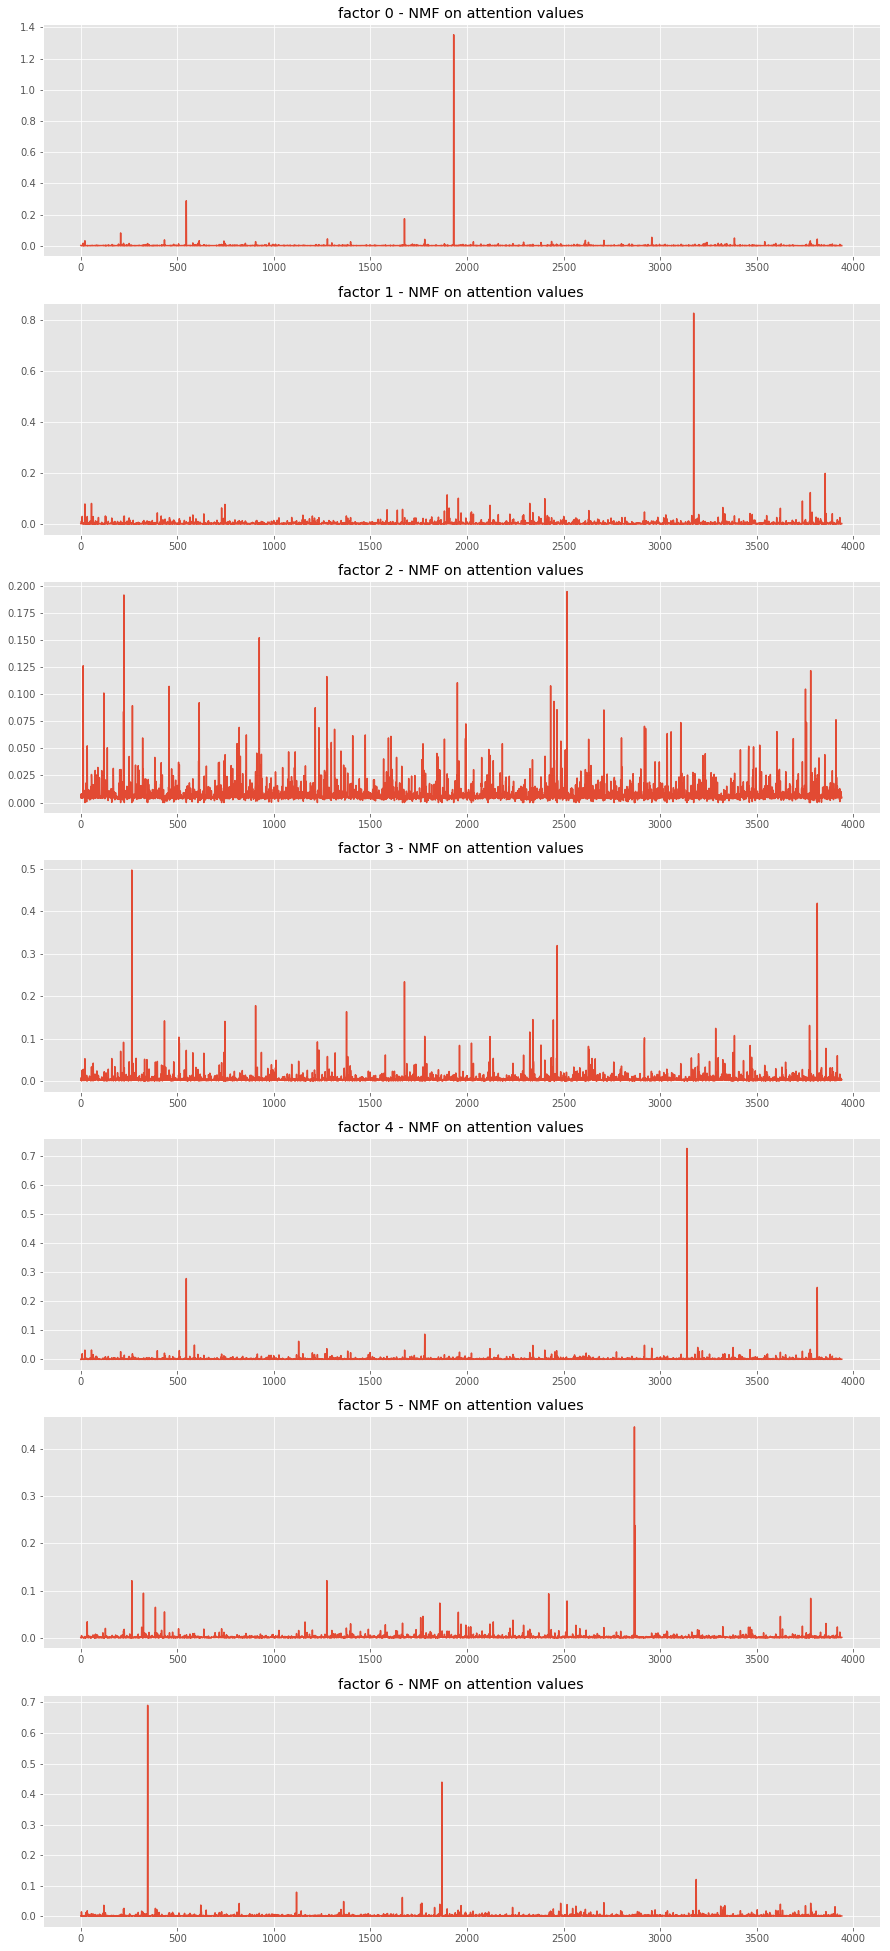

In [10]:
print('W obtained from NMF on attention values')
fig, axes = plt.subplots(nrows=7, figsize=(15, 5*7))
for i in range(7):
    idxs = H[i].argsort()[::-1][:5]
    print()
    print('factor', i)
    for idx in idxs:
        print(pathway_df.columns[idx], '{:.4f}'.format(H[i][idx]))

    axes[i].plot(np.arange(H.shape[1]), H[i])
    axes[i].set_title('factor {} - NMF on attention values'.format(i))
    

<hr>

## NMF on pathways

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

In [12]:
cols = pathway_df.columns[:-2]
X_train = pathway_df.loc[train_idxs][cols].values
y_train = pathway_df.loc[train_idxs]['PAM50'].apply(lambda x: c2i[x]).values

In [13]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train).toarray()

In [14]:
nmf = NMF(n_components=7)
W = nmf.fit_transform(X_train)
H = nmf.components_

Text(0.5, 1.0, 'W obtained from NMF applied on pathways - training data')

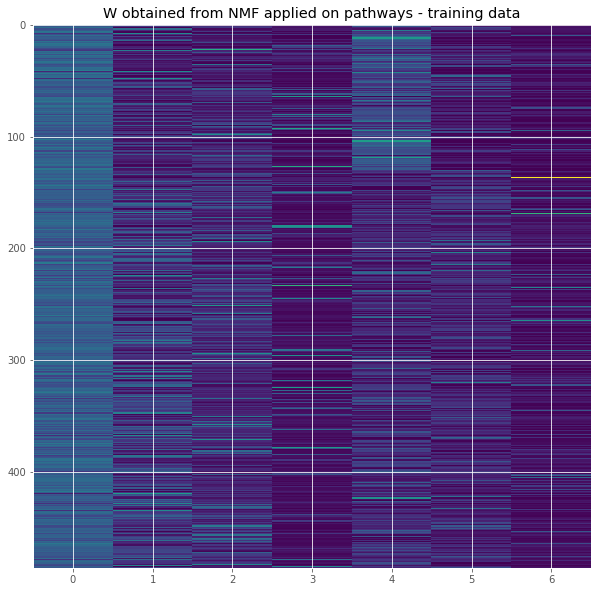

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
W_ = np.vstack([W[y_train==0], W[y_train==1]])
ax.imshow(W_, aspect='auto')
ax.set_title("W obtained from NMF applied on pathways - training data")

In [16]:
X_test = pathway_df.loc[test_idxs][cols].values
y_test = pathway_df.loc[test_idxs]['PAM50'].apply(lambda x: c2i[x]).values
X_test = tfidf.transform(X_test)

Text(0.5, 1.0, 'W obtained from NMF applied on pathways - test data')

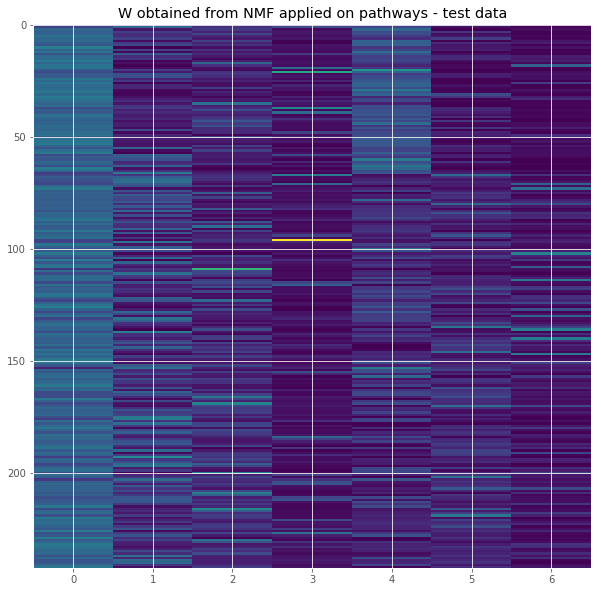

In [17]:
W_test = nmf.transform(X_test)
fig, ax = plt.subplots(figsize=(10, 10))
W_ = np.vstack([W_test[y_test==0], W_test[y_test==1]])
ax.imshow(W_, aspect='auto')
ax.set_title("W obtained from NMF applied on pathways - test data")

W obtained from NMF on pathways

factor 0
GO:0045944 1.1975
GO:0006351 1.0016
GO:0000122 0.8584
GO:0007165 0.8528
GO:0006355 0.7069

factor 1
GO:0030198 0.9859
GO:0030574 0.6957
GO:0001501 0.6234
GO:0030199 0.5930
GO:0071230 0.5722

factor 2
GO:0006413 0.7473
GO:0006412 0.7320
GO:0000184 0.7294
GO:0006364 0.7220
GO:0006614 0.7103

factor 3
GO:0007165 0.2956
GO:0044267 0.2634
GO:0043568 0.2272
GO:0045944 0.1931
GO:0008284 0.1911

factor 4
GO:0007165 0.3268
GO:0043312 0.2406
GO:0045893 0.2072
GO:0016032 0.2026
GO:0043066 0.1901

factor 5
GO:0043312 0.3169
GO:0007165 0.2465
GO:0043066 0.2436
GO:0045944 0.2365
GO:0043123 0.2135

factor 6
GO:0006508 0.5186
GO:0043312 0.1826
GO:0010628 0.1766
GO:0007165 0.1764
GO:0044267 0.1696


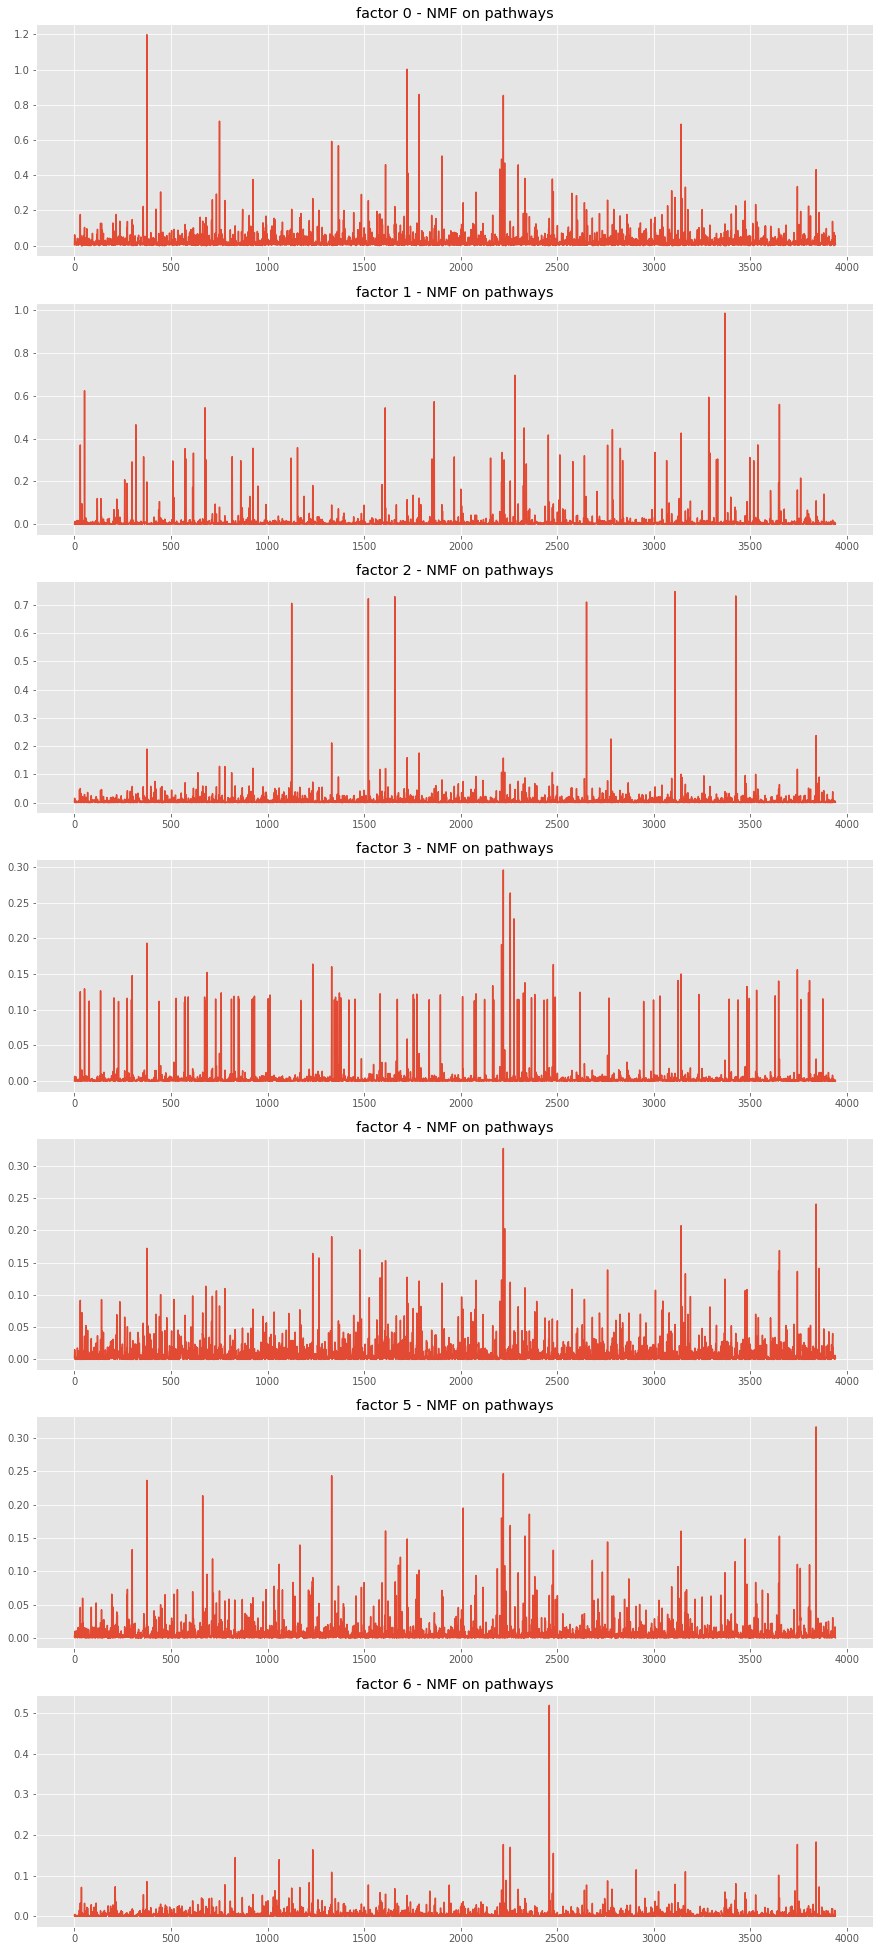

In [19]:
print('W obtained from NMF on pathways')
fig, axes = plt.subplots(figsize=(15, 5*7), nrows=7)
for i in range(7):
    idxs = H[i].argsort()[::-1][:5]
    print()
    print('factor', i)
    for idx in idxs:
        print(pathway_df.columns[idx], '{:.4f}'.format(H[i][idx]))

    axes[i].plot(np.arange(H.shape[1]), H[i])
    axes[i].set_title('factor {} - NMF on pathways'.format(i))
     